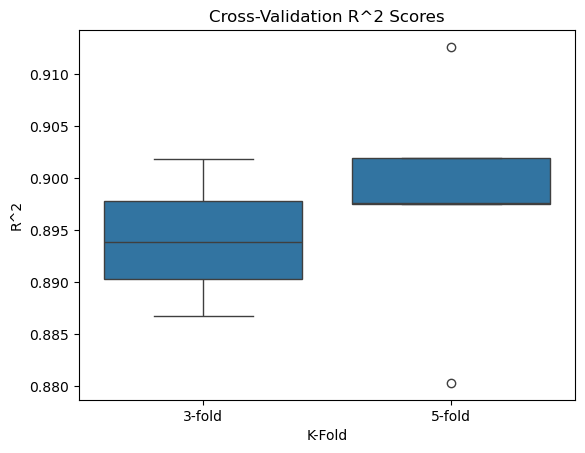

Final Evaluation Metrics for the Polynomial Regression Model:


,Metric,Value
0,R^2,0.907492
1,MSE,23.721779
2,Accuracy,0.955000
3,F1 Score,0.969492
4,ROC AUC,0.984603


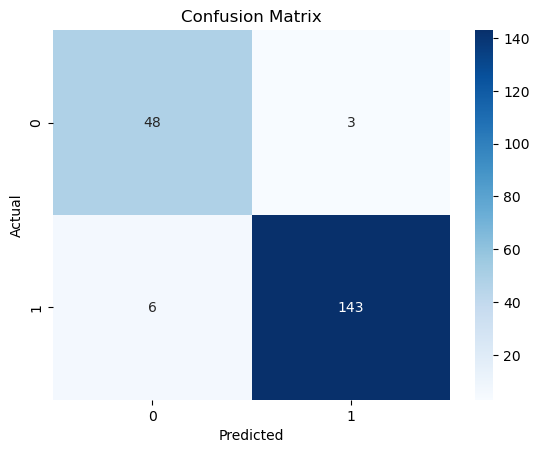

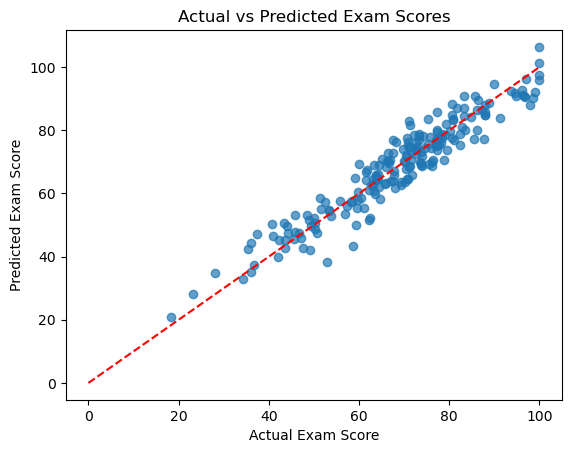

Polynomial Regression:
Best configuration for lowest Validation MSE: {'model': 'PolynomialRegression', 'degree': 2, 'scaler': 'StandardScaler', 'k_folds': 5}
Validation MSE: 29.7315
Test MSE: 23.7218, Test R2: 0.9075, Test Accuracy: 95.50%

Best configuration for highest Validation R2: {'model': 'PolynomialRegression', 'degree': 2, 'scaler': 'StandardScaler', 'k_folds': 5}
Validation R2: 0.8980
Test MSE: 23.7218, Test R2: 0.9075, Test Accuracy: 95.50%

Best configuration for highest Validation Accuracy: {'model': 'PolynomialRegression', 'degree': 2, 'scaler': 'StandardScaler', 'k_folds': 5}
Validation Accuracy: N/A (regression-based)
Test MSE: 23.7218, Test R2: 0.9075, Test Accuracy: 95.50%


['encoder.pkl']

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline

# load / inspect Data
df = pd.read_csv("students.csv")
df.head()

# feature selection
keep_features = [
    'study_hours_per_day', 'social_media_hours', 'netflix_hours',
    'attendance_percentage', 'sleep_hours', 'diet_quality',
    'exercise_frequency', 'mental_health_rating', 'exam_score'
]
df = df[keep_features]


# encode categorical vars
le = LabelEncoder()
df['diet_quality'] = le.fit_transform(df['diet_quality'])

# train-test split
X = df.drop(columns=['exam_score'])
y = df['exam_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# polynomial model (degree 2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

model = LinearRegression()
model.fit(X_train_poly, y_train)
y_pred = model.predict(X_test_poly)

# k fold cross validation
cv_results = {}

for k in [3, 5]:
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train_poly, y_train, cv=kf, scoring='r2')
    cv_results[f"{k}-fold"] = scores


# boxplot of cross validation scores
# convert to long form DataFrame
cv_df = pd.DataFrame([(fold, score) for fold, scores in cv_results.items() for score in scores],
                     columns=["K-Fold", "R2 Score"])

# plot
sns.boxplot(x="K-Fold", y="R2 Score", data=cv_df)
plt.title("Cross-Validation R^2 Scores")
plt.ylabel("R^2")
plt.show()


# drop each feature (except study_hours, mental_health)
results = []
features_to_drop = [f for f in X.columns if f not in ['study_hours_per_day', 'mental_health_rating']]

for feature in features_to_drop:
    X_temp = X.drop(columns=[feature])
    X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(X_temp, y, test_size=0.2, random_state=42)
    X_train_temp_scaled = scaler.fit_transform(X_train_temp)
    X_test_temp_scaled = scaler.transform(X_test_temp)
    X_train_temp_poly = poly.fit_transform(X_train_temp_scaled)
    X_test_temp_poly = poly.transform(X_test_temp_scaled)
    model.fit(X_train_temp_poly, y_train_temp)
    y_pred_temp = model.predict(X_test_temp_poly)
    r2 = r2_score(y_test_temp, y_pred_temp)
    mse = mean_squared_error(y_test_temp, y_pred_temp)
    results.append((feature, r2, mse))

drop_df = pd.DataFrame(results, columns=["Dropped Feature", "R2 Score", "MSE"])
drop_df

# evaluation metrics
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# convert predictions to classes for classification metrics (threshold: 60)
y_pred_class = (y_pred >= 60).astype(int)
y_test_class = (y_test >= 60).astype(int)


accuracy = accuracy_score(y_test_class, y_pred_class)
f1 = f1_score(y_test_class, y_pred_class)
conf_matrix = confusion_matrix(y_test_class, y_pred_class)
roc_auc = roc_auc_score(y_test_class, y_pred)

# summary table
summary = pd.DataFrame({
    "Metric": ["R^2", "MSE", "Accuracy", "F1 Score", "ROC AUC"],
    "Value": [r2, mse, accuracy, f1, roc_auc]
})
summary
print("Final Evaluation Metrics for the Polynomial Regression Model:")
display(summary)

# confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# predicted vs actual plot
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([0, 100], [0, 100], '--', color='red')
plt.xlabel("Actual Exam Score")
plt.ylabel("Predicted Exam Score")
plt.title("Actual vs Predicted Exam Scores")
plt.show()


# configuration details for print
model_config = {
    'model': 'PolynomialRegression',
    'degree': 2,
    'scaler': 'StandardScaler',
    'k_folds': 5
}

# cross-validation metrics
kf = KFold(n_splits=model_config['k_folds'], shuffle=True, random_state=42)
val_r2_scores = cross_val_score(model, X_train_poly, y_train, cv=kf, scoring='r2')
val_mse_scores = -cross_val_score(model, X_train_poly, y_train, cv=kf, scoring='neg_mean_squared_error')

# average validation scores
val_r2 = np.mean(val_r2_scores)
val_mse = np.mean(val_mse_scores)

# test scores
test_r2 = r2_score(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_accuracy = accuracy_score(y_test_class, y_pred_class) * 100  # as percentage

# summaries formatted
print("Polynomial Regression:")
print(f"Best configuration for lowest Validation MSE: {model_config}")
print(f"Validation MSE: {val_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}, Test R2: {test_r2:.4f}, Test Accuracy: {test_accuracy:.2f}%\n")

print(f"Best configuration for highest Validation R2: {model_config}")
print(f"Validation R2: {val_r2:.4f}")
print(f"Test MSE: {test_mse:.4f}, Test R2: {test_r2:.4f}, Test Accuracy: {test_accuracy:.2f}%\n")

print(f"Best configuration for highest Validation Accuracy: {model_config}")
print(f"Validation Accuracy: N/A (regression-based)")  # not applicable unless you bin scores during CV
print(f"Test MSE: {test_mse:.4f}, Test R2: {test_r2:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Model saving
joblib.dump(model, "model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(poly, "poly.pkl")
joblib.dump(le, "encoder.pkl")